# Équation de Helmholtz 1D avec condition de Robin sur le bord

$$
\left\{
\begin{array}{ll}
    -\partial_{xx}^2u-\omega^{2}u=f &\text{ dans }\left]a,b\right[\\
    \partial_{n}u+i\omega u=g & \text{ en a et b}
\end{array}
\right.
$$

## Éléments finis $\mathbb{P}_{2}$

On va chercher les solutions sous la forme
$$
\widetilde{u}=\sum_{k=0}^{N-1} c_{k}\varphi_{k}
$$
avec $\varphi_{k}$ construite à l'aide d'une des fonctions de forme
$$
\left\{
\begin{array}{ll}
    \widehat{\varphi}_{1}(x)=(2x-1)(x-1)\\
    \widehat{\varphi}_{2}(x)=4x(1-x)\\
    \widehat{\varphi}_{3}(x)=x(2x-1)\\
\end{array}
\right.
$$
et des translations $\tau_{k}(x)=\frac{x-x_{k-1}}{x_{k+1}-x_{k-1}}$

### Imports & données du problème

In [1]:
%matplotlib notebook

import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.linalg import solve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy
from enum import Enum

def z(x):
    return 0.0

#pulsation
omega=100

#f : second membre
f=z
#g : fct bord
g=[0.0, complex(-2*omega*np.sin(omega), 2*omega*np.cos(omega))]
#intervalle ]a,b[
a=0.0
b=1
#frequence de maillage (EN 2K+1 !!!)
N=101

### Classe du solver éléments finis

In [2]:
#Cette classe servira à savoir si l'on prend la "partie droite" ou la "partie gauche" des fonctions de forme
class DIRECTION(Enum):
    GAUCHE = 0
    DROITE = 1
    
class Solver:
    
    #@Brief
    #    Constructeur
    #@Param
    #   Omega : Pulsation
    #   f     : Second membre du problème 
    #   g     : Condition de bord
    #   a, b  : Intervalle
    #   N     : Nombre de points pour le maillage (doit être en 2K+1 !!)
    def __init__(self, omega=10, f=z, g=[0.0, complex(-2*omega*np.sin(omega), 2*omega*np.cos(omega))], a=0, b=1, N=101):
        if(not N&0b1):
            print("N must be odd")
        if(N<5):
            print("Choose N >= 5")
        self.omega=omega
        self.f=f
        self.g=g
        self.N=N
        self.x=np.linspace(a, b, N)
        self.h=self.x[1]-self.x[0]
        
    #@Brief
    #    Fonction de forme transformée par la fonction affine
    #@Warning
    #    Attention, ne se préoccupe pas de l'extérieur du support !
    #@Param
    #    k         : Indice de la fonction
    #    direction : Revient à prendre [0,0.5] ou [0.5,1] pour les fonctions à indice pair
    #    x         : Variable
    def phi(self, k, direction, x):
        if(k & 0b1):                              #k impair -> phi2 o T(k)
            x=(x-self.x[k-1])/2/self.h              # |
            return 4*x*(1-x)                        # |
        else:                                     #k pair
            if(direction == DIRECTION.GAUCHE):      #phi3 o T(k-1)
                x=(x-self.x[k-2])/2/self.h            # |
                return x*(2*x-1)                      # |
            else:                                   #phi1 o T(k+1)
                x=(x-self.x[k])/2/self.h              # |
                return (2*x-1)*(x-1)                  # |
            
    #Fonction de forme transformée par la fonction affine
    #Attention, ne se préoccupe pas de l'extérieur du support !
    def dphi(self, k, direction, x):
        if(k & 0b1):                              #k impair -> phi2 o T(k)
            x=(x-self.x[k-1])/2/self.h              # |
            return 4-8*x                            # |
        else:                                     #k pair
            if(direction == DIRECTION.GAUCHE):      #phi3 o T(k-1)
                x=(x-self.x[k-2])/2/self.h            # |
                return 4*x-1                          # |
            else:                                   #phi1 o T(k+1)
                x=(x-self.x[k])/2/self.h              # |
                return 4*x-3                          # |        
    
    #Assemblage de la matrice
    #@Brief
    #    Assemble la matrice A après construction des matrices K et M, toutes deux 5-diagonales symétriques
    #    construites à partir des fonctions de forme et de leur dérivée, sans oublier les conditions de bord.
    def buildMatrix(self):
        
        #Les diagonales de K (matrice symétrique, 3 suffisent)
        K1=np.zeros(self.N-2)
        K2=np.zeros(self.N-1)
        K3=np.zeros(self.N)
        
        #Les diagonales de M (matrice symétrique, 3 suffisent)
        M1=np.zeros(self.N-2)
        M2=np.zeros(self.N-1)
        M3=np.zeros(self.N)
        
        
        ######################################### Construction de K ####################################
        for i in range((int)(self.N/2)):#1 sur 2
            K1[2*i]=1
        for i in range(self.N-1):
            K2[i]=-8
        for i in range(1,(int)(self.N/2)):#A partir du 3e, de 2 en 2 -> 14 et à partir du 4e, de 2 en 2 -> 16
            K3[2*i]=14
            K3[2*i+1]=16
            
        #Il reste ces trois cas non traités par la boucle précédente
        K3[0]=7
        K3[-1]=7
        K3[1]=16
        
        K=[K1, K2, K3, K2, K1]
        K=diags(K, [-2,-1, 0, 1, 2], dtype=complex)
        
        
        ######################################### Construction de M ####################################
        for i in range((int)(self.N/2)):#1 sur 2
            M1[2*i]=-1
        for i in range(self.N-1):
            M2[i]=2
        for i in range(1,(int)(self.N/2)):#A partir du 3e, de 2 en 2 -> 8 et à partir du 4e, de 2 en 2 -> 16
            M3[2*i]=8
            M3[2*i+1]=16
        #Il reste ces trois cas non traités par la boucle précédente
        M3[0]=4
        M3[-1]=4
        M3[1]=16
        M=[M1, M2, M3, M2, M1]
        M=diags(M, [-2,-1, 0, 1, 2], dtype=complex)
        
        
        ######################################### Assemblage de A avec K et M ####################################
        #   K <- K/6h    M <- M*h/15
        #A= K - w^2 M
        self.A=(1/6/self.h*K-self.omega*self.omega*self.h/15*M)       
     
        #+ iw aux extrémités diagonales
        self.A[0,0]+=complex(0,self.omega)
        self.A[-1,-1]+=complex(0,self.omega)
        
    #integ f*phik (gauche ou droite)
    #@Brief
    #    Calcule l'intégrale du produit de f par une fonction de base phi_k. Pour rappel, phi_k s'étale sur [x_k-2, x_k+2],
    #    il nous faut donc connaitre l'intervalle de calcul [x_k-2, x_k] pour gauche et [x_k, x_k+2] pour droite 
    #    (dans le cas k pair)
    #@Param
    #    k         : Indice de la fonction de base
    #    direction : [x_k-2, x_k] ou [x_k, x_k+2]
    #    res       : Résolution de calcul pour l'intégrale
    def integPhi(self, k, direction, res):
        a=0.0
        b=0.0
        if(k&0b1):          #k impair
            a=self.x[k-1]
            b=self.x[k+1]
        else:               #k pair
            if(direction == DIRECTION.GAUCHE):
                a=self.x[k-2]
                b=self.x[k]
            else:
                a=self.x[k]
                b=self.x[k+2]
                
        pas = (b-a)/res
        x=a
        s=0.0
        for i in range(res):
            s+=(self.f(x)*self.phi(k, direction, x)+self.f(x+pas)*self.phi(k, direction, x+pas))*pas/2.0
            x+=pas
        return s
    
    #Assemblage second membre
    #@Brief
    #    Calcul du second membre b. Sur un double intervalle du type [x_2k, x_2k+2] ne vivent que 3 fonctions de base.
    #    Le calcul se fait donc par double intervalle
    def buildVector(self):
        self.b = np.zeros(self.N, dtype=complex)
        
        #b=int(f, phi) (Écriture 1-2-3, puis 3-4-5, puis 5-6-7, etc.)
        for k in range((int)((self.N-1)/2)):#On parcourt les intervalles Ik de la forme [xk, xk+1]
            self.b[2*k]+=self.integPhi(2*k, DIRECTION.DROITE, 1000)
            self.b[2*k+1]=self.integPhi(2*k+1, DIRECTION.DROITE, 1000)
            self.b[2*k+2]=self.integPhi(2*k+2, DIRECTION.GAUCHE, 1000)
            
        #cdts de bord
        self.b[0]+=self.g[0]
        self.b[-1]+=self.g[1]

    #A 5-diagonale et donc creuse
    #@Brief
    #    Calcule la solution du système linéaire, solveur de matrice creuse par défaut
    #@Param
    #    A : Matrice du système linéaire
    #    b : Second memebre du système linéaire
    #@ToDo Solveur matrice 5-diagonale
    def defaultLinearSolver(A, b):
        return spsolve(A, b)
    
    #Définition et résolution du systeme lineaire
    #@Brief
    #    Assemble la matrice et le second membre, puis résout avec le solver donné
    #@Param
    #    linearSolver : Le solveur du système linéaire à utiliser
    def solve(self, linearSolver = defaultLinearSolver):
        self.buildMatrix()
        self.buildVector()
        
        return linearSolver(self.A, self.b)
    
    #Affichage de la solution avec resByMesh points sur chaque [x_k, x_k+1[
    #@Brief
    #    Calcule la solution à partir d'une certaine résolution.
    #    Du point de gauche de la maille compris au point de droite exclu, il y a exactement resByMesh points
    #    Il faut donc ajouter le dernier point de droite à la fin si l'on parcourt par double intervalle
    #@Param
    #    c         : Solution du système linéaire
    #    resByMesh : Résolution d'affichage par maille
    def plot(self, c, resByMesh):
        a=self.x[0]
        b=self.x[-1]
        t=np.linspace(a,b,resByMesh*(self.N-1)+1) #resByMesh points sur [xk,xk+1[
        y=np.zeros(len(t), dtype=complex)
        for k in range((int)((self.N-1)/2)):
            base = 2*k*resByMesh
            for i in range(2*resByMesh):
                ti = base + i
                #Somme des fonctions locales
                y[ti]=c[2*k]*self.phi(2*k, DIRECTION.DROITE, t[ti]) + \
                    c[2*k+1]*self.phi(2*k+1, DIRECTION.DROITE, t[ti]) + \
                    c[2*k+2]*self.phi(2*k+2, DIRECTION.GAUCHE, t[ti])
        y[-1]= c[-1]*self.phi(self.N-1, DIRECTION.GAUCHE, t[-1])
        
        #Affichage 3D (real -> complex)
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(t, y.real, y.imag, s=0.5)
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_zlabel('Z-axis')        
        plt.show()
        
        #Projection sur les réels
        fig = plt.figure()
        plt.title("$Re(\widetilde{u})$")
        plt.plot(t, y.real)
        plt.show()
        
        #Projection sur les imaginaires
        fig = plt.figure()
        plt.title("$Im(\widetilde{u})$")
        plt.plot(t, y.imag)
        plt.show()

### Résolution & affichage
$
\left\{
\begin{array}{ll}
a=0\\
b=1\\
f=0\\
g(0)=0\\
g(1)=2i\omega e^{i\omega}
\end{array}
\right. \Longrightarrow u(x)=e^{i\omega x}$

<IPython.core.display.Javascript object>


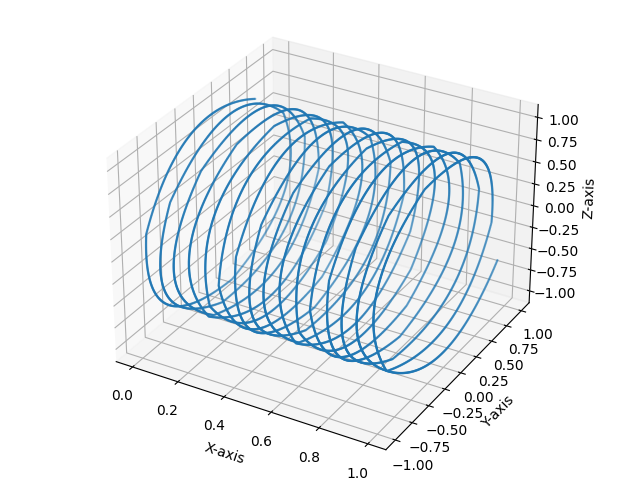

<IPython.core.display.Javascript object>


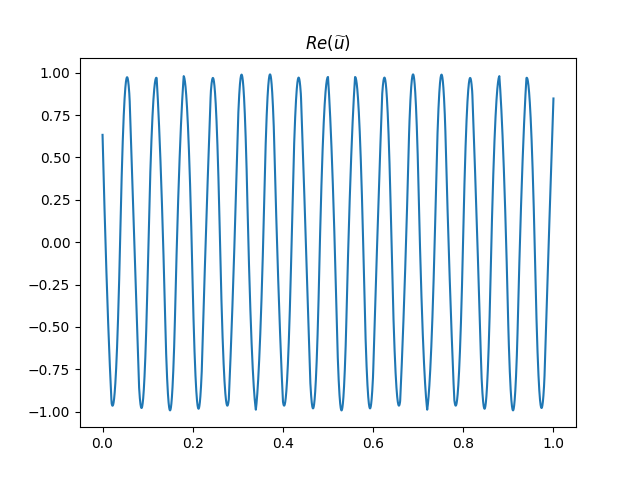

<IPython.core.display.Javascript object>


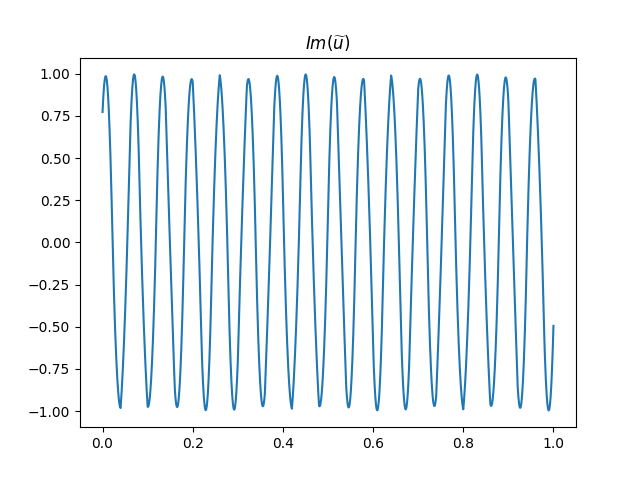

In [3]:
s = Solver(omega, f, g, a, b, N)
c = s.solve()
s.plot(c, 100)

## Décomposition de domaine

Nous nous plaçons ici dans un cas particulier où nous devons résoudre le problème suivant
$$
\left\{
\begin{array}{ll}
    -\partial_{xx}^2u-\omega^{2}u=0 &\text{ dans }\left]a,b\right[\\
    \partial_{n}(u-u_{inc})+i\omega (u-u_{inc})=0 & \text{ en a et b}
\end{array}
\right.
$$
avec $u_{inc}(x)=e^{i\omega x}$

Nous partitionnons ensuite $I$ grâce à $N$ points : $a=x_0 < x_1 < ... < x_{N-2} < x_{N-1} = b$

Les transmissions aux noeuds intérieurs s'écrivent donc

$
\begin{pmatrix}
    T_{s}u(x_k)\\
    T_{s}u(x_{k+1})
\end{pmatrix}
=
\begin{pmatrix}
    0 & e^{iwh}\\
    e^{iwh} & 0
\end{pmatrix}
\begin{pmatrix}
    T_{e}u(x_k)\\
    T_{e}u(x_{k+1})
\end{pmatrix}=
S
\begin{pmatrix}
    T_{e}u(x_k)\\
    T_{e}u(x_{k+1})
\end{pmatrix} k=1,...,N-3$

$\left\{
\begin{array}{ll}
\partial_{n}u_{k+\frac{1}{2}}(x_{k+1})+i\omega u_{k+\frac{1}{2}}(x_{k+1}) &= -\partial_{n} u_{k+\frac{3}{2}}(x_{k+1}) + i\omega u_{k+\frac{3}{2}}(x_{k+1}) \\
\partial_{n}u_{k+\frac{1}{2}}(x_{k})+i\omega u_{k+\frac{1}{2}}(x_{k}) &= -\partial_{n} u_{k-\frac{1}{2}}(x_{k}) + i\omega u_{k-\frac{1}{2}}(x_{k})
\end{array}
\right.$

qui se réécrit en forme compacte 

$\left\{
\begin{array}{ll}
T_{s}u_{k+\frac{1}{2}}(x_{k+1}) &= T_{e}u_{k+\frac{3}{2}}(x_{k+1}) \\
T_{s}u_{k+\frac{1}{2}}(x_{k}) &= T_{e}u_{k-\frac{1}{2}}(x_{k}) \\
\end{array}
\right.$

$T_{e}u_{k+\frac{3}{2}}(x_{k+1})$ et $T_{e}u_{k-\frac{1}{2}}(x_{k+1})$ étant obtenus avec $S$.

Avec les conditions au bord qui diffèrent un peu

$\left\{
\begin{array}{llrll}
T_{s}u_{N-\frac{1}{2}}(x_{N-1}) &= g(x_{N-1}) &\text{ et }& T_{s}u_{N-\frac{1}{2}}(x_{N-2}) &= T_{e}u_{N-\frac{3}{2}}(x_{N-2})\\
T_{s}u_{\frac{1}{2}}(x_{0}) &= g(x_{0}) &\text{ et }& T_{s}u_{\frac{1}{2}}(x_{1}) &= T_{e}u_{\frac{3}{2}}(x_{1})\\
\end{array}
\right.$

### Classe Solver décomposition de domaine

In [37]:
class DomainDecompositionSolver:
    
    #Constructeur
    #@Param
    #    a, b : Intervalle de résolution 
    #    N    : Nombre de points pour la décomposition de domaine (impair pour un nombre pair d'intervalle)
    #    N2   : Tableau de nombres de points pour le maillage des éléments finis, par sous-domaine (taille N-1 & N2[i] impair qqs i)
    #    f    : Second membre
    #    g    : Conditions de bord
    def __init__(self, a, b, N, N2, omega, g):
        if(isinstance(N2, int)):
            N2 = [N2 for i in range(N-1)]
        elif(len(N2) != N-1):
            lN2 = len(N2)
            print("N2 has incorrect size ! Has %d, expected %d" % (lN2, N-1))
            if(lN2 > N-1):#Si trop d'éléments, on tronque
                N2 = N2[:N-1]
            else:#Sinon on rajoute une valeur par défaut
                N2.extend([N2[-1] for i in range(N-1-lN2)])
        
        self.omega = omega
        self.N=N
        self.x=np.linspace(a,b,self.N)
        self.N2=N2
        
        #vecteurs de transmission
        self.trans=np.zeros((self.N-1, 2), dtype=complex)
        
        self.g=g
        
        self.trans[0][0]=self.g[0]
        self.trans[-1][1]=self.g[1]
        
        #Largeur d'un sous-domaine
        self.h = self.x[1]-self.x[0]
        
        #Matrice pour passer des traces sortantes à entrantes
        self.S = np.matrix([[0, complex(np.cos(self.omega*self.h), -np.sin(self.omega*self.h))],\
                           [complex(np.cos(self.omega*self.h), -np.sin(self.omega*self.h)), 0]])
        
        #u va représenter la solution sur chaque sous-domaine
        self.u=np.array([np.zeros(tailleSousDomaine, dtype=complex) for tailleSousDomaine in N2], dtype=object)

        #Solvers EF sur chaque sous-domaine
        self.solvers=np.array([Solver(self.omega, z, self.trans[k], self.x[k], self.x[k+1], self.N2[k]) for k in range(N-1)], dtype=object)
        
    #Transmission sur les intervalles de I_0 à I_it compris et symétrique en partant de la fin
    #@Brief
    #    Calcule les traces entrantes en fonction des traces sortantes sur chaque sous-domaine
    #    puis effectue la transmission
    def transmission(self):
        te=np.zeros((self.N-1, 2), dtype=complex)#traces entrantes
        
        for k in range(self.N-1):#boucle sous-domaines 
            te[k]=self.S.dot(self.trans[k])#Te=S*Ts
        
        for k in range(1,self.N-2):#boucle sous-domaines intérieurs
            self.trans[k][0]=te[k-1][1]
            self.trans[k][1]=te[k+1][0]
        
        #Sous-domaines extérieurs
        self.trans[0][0]=self.g[0]
        self.trans[0][1]=te[1][0]
        
        self.trans[-1][0]=te[-2][1]
        self.trans[-1][1]=self.g[1]
        
    #Test de résolution analytique
    #@Brief
    #    Résout le problème avec les conditions actuelles dans self.trans comme condition aux bord
    #    pour f = 0 -> u_k(x)=A_k e^{-iw(x-x_(k))}+B_k e^{iw(x-x_(k+1))} avec A_k et B_k déterminés par self.trans[k] (cdts de bord)
    def test_solve(self):
        for k in range(self.N-1):#Résolution sur chaque sous-domaine
                A=self.trans[k][0]/complex(0,2*self.omega)
                B=self.trans[k][1]/complex(0,2*self.omega)
                for j in range(self.N2[k]):
                    currX = self.solvers[k].x[j]#abscisse
                    
                    #Pour la lisibilité Ae^{-iwx}+Be^{iwx}
                    self.u[k][j]=A*complex(np.cos(self.omega*(self.x[k]-currX)), np.sin(self.omega*(self.x[k]-currX)))+\
                                B*complex(np.cos(self.omega*(currX-self.x[k+1])), np.sin(self.omega*(currX-self.x[k+1])))
    
    #Résolution partielle pour une itération
    #@Brief
    #    Calcule de la solution sur chaque sous domaine en fonction des conditions de bord actuelles
    def solveOnEachSubDomain(self):
        for k in range(self.N-1):#Résolution sur chaque sous-domaine
                self.u[k]=self.solvers[k].solve()
    
    #Résolution
    #@Brief
    #    Résout le problème sur chaque sous-domaine puis effectue la transmission
    #    et répète cela
    #@Param
    #    analytic : Si vrai, fait le calcul de u "à la main". Si faux, avec les solveurs éléments finis.
    def solve(self, analytic=True):
        
        #La fonction qui va être utilisée pour résoudre (analytique ou EF)
        def localSolve(self):
            if analytic:
                self.test_solve()
            else:
                self.solveOnEachSubDomain()
                
        for it in range(1,self.N):#itération
            localSolve(self)
            self.transmission()
    
    
    
    #Calculs après résolution
    #@Brief
    #    Calcule l'erreur entre la solution calculée et la solution attendue
    #@Param
    #    uExpected : La solution attendue
    def postProcess(self, uExpected=lambda x: complex(np.cos(omega*x), np.sin(omega*x))):
        err = 0
        normExpected = 0
        for k in range(self.N-1):
            for j in range(self.N2[k]):
                err += abs(self.u[k][j]-uExpected(self.solvers[k].x[j]))**2
                normExpected += abs(uExpected(self.solvers[k].x[j]))**2
        if normExpected:#sinon la notion d'erreur relative n'a pas grand sens
            err/=normExpected
        return np.sqrt(err)
        
        
    #Affichage de la solution
    #@Brief
    #    Affiche la solution avec exactement resByMesh points sur chaque maille
    #@Param
    #    resByMesh : Résolution de l'affichage
    def plot(self, resByMesh):
        s=sum(self.N2)-self.N+1
        t=np.linspace(self.x[0], self.x[-1], resByMesh*s+1)
        y=np.zeros(resByMesh*s+1, dtype=complex)
        
        globalIndexInterval = 0
        globalIndexMesh = 0
        for k in range(self.N-1):#boucle intervalle
            for j in range((int)((self.N2[k]-1)/2)):#boucle maille
                for l in range(2*resByMesh):
                    globalIndex = globalIndexMesh + l
                    y[globalIndex] = self.u[k][2*j]*self.solvers[k].phi(2*j, DIRECTION.DROITE, t[globalIndex]) +\
                                    self.u[k][2*j+1]*self.solvers[k].phi(2*j+1, DIRECTION.DROITE, t[globalIndex]) +\
                                    self.u[k][2*j+2]*self.solvers[k].phi(2*j+2, DIRECTION.GAUCHE, t[globalIndex])
                globalIndexMesh += 2*resByMesh
            globalIndexInterval += len(self.u[k])-1

        y[-1] = self.u[-1][-1]*self.solvers[-1].phi(self.N2[-1]-1, DIRECTION.GAUCHE, t[-1])
        
        #Affichage 3D (real -> complex)
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(t, y.real, y.imag, s=0.5)
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_zlabel('Z-axis')        
        plt.show()
        
        #Projection sur les réels
        fig = plt.figure()
        plt.title("$Re(\widetilde{u})$")
        plt.plot(t, y.real)
        plt.show()
        
        #Projection sur les imaginaires
        fig = plt.figure()
        plt.title("$Im(\widetilde{u})$")
        plt.plot(t, y.imag)
        plt.show()

In [38]:
omega=100

g=[0.0, complex(-2*omega*np.sin(omega), 2*omega*np.cos(omega))]
s = DomainDecompositionSolver(0, 1, 10, 101, omega, g)

<IPython.core.display.Javascript object>


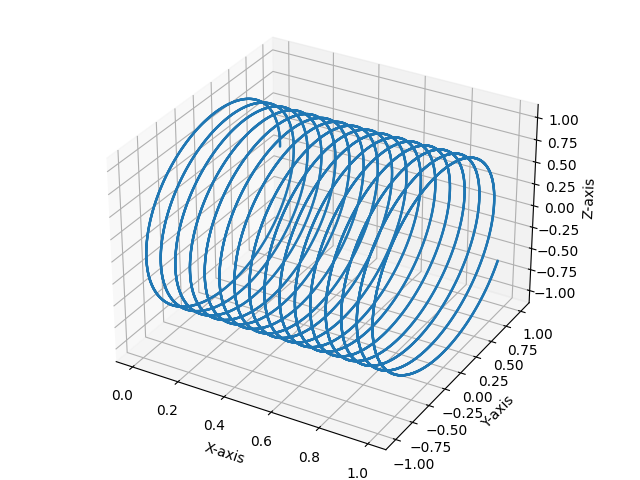

<IPython.core.display.Javascript object>


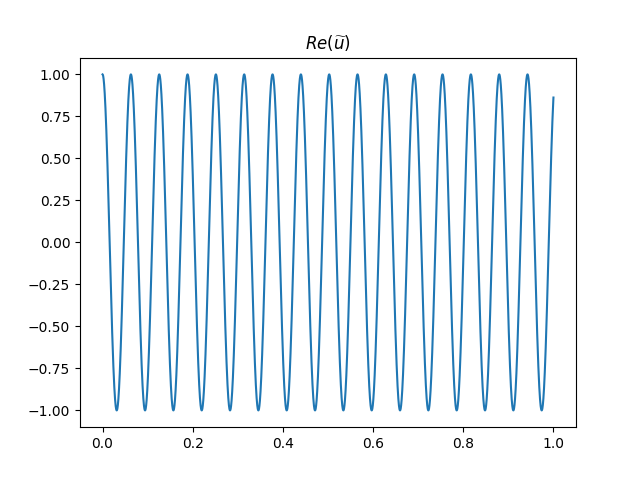

<IPython.core.display.Javascript object>


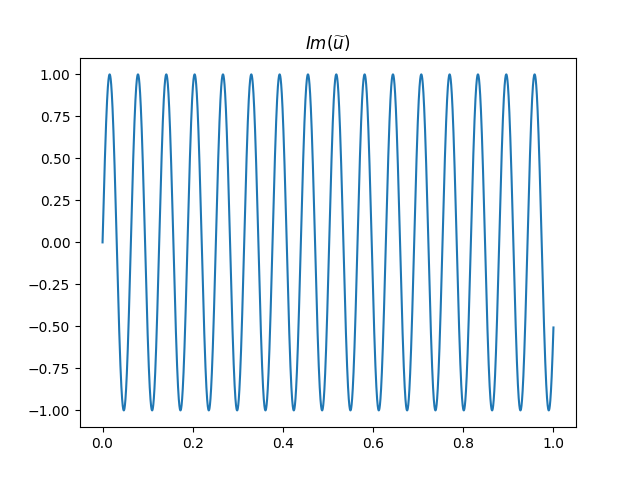

L'erreur relative est de 0.000011


In [39]:
s.solve(False)
s.plot(50)
print("L'erreur relative est de %f" %(s.postProcess()))

### Convergence numérique

In [ ]:
omega=100

g=[0.0, complex(-2*omega*np.sin(omega), 2*omega*np.cos(omega))]

pasDecompositionDomaine=[10*i for i in range(1, 11)]#Lignes
pasElementsFinis=[20*i+1 for i in range(1, 11)]#Colonnes

solvers=np.array([[DomainDecompositionSolver(0, 1, i, j, omega, g)\
                   for j in pasElementsFinis] for i in pasDecompositionDomaine], dtype=object)
errorsAnalytic = np.zeros((len(pasDecompositionDomaine), len(pasElementsFinis)), dtype=float)

for i in range(len(pasDecompositionDomaine)):
    for j in range(len(pasElementsFinis)):
        solvers[i][j].solve()
        errorsAnalytic[i][j]=solvers[i][j].postProcess()
        
errors = np.zeros((len(pasDecompositionDomaine), len(pasElementsFinis)), dtype=float)

for i in range(len(pasDecompositionDomaine)):
    for j in range(len(pasElementsFinis)):
        solvers[i][j].solve(False)
        errors[i][j]=solvers[i][j].postProcess()

In [ ]:
X,Y=np.meshgrid(pasElementsFinis, pasDecompositionDomaine)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, errorsAnalytic)
ax.set_xlabel('N éléments finis')
ax.set_ylabel('N décomposition de domaine')
ax.set_zlabel('Erreur relative analytique')        
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, errors)
ax.set_xlabel('N éléments finis')
ax.set_ylabel('N décomposition de domaine')
ax.set_zlabel('Erreur relative')        
plt.show()